In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
batch_size = 64
img_size = 32
patch_size = 4
num_channels = 3
num_patches = (img_size // patch_size) ** 2
num_heads = 4
embed_dim = 128
mlp_dim = 256
transformer_units = 6

In [ ]:
# Transform for CIFAR-10
import torchvision.transforms as T
from torchvision.transforms.autoaugment import RandAugment

train_transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=9),
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616)),
    T.RandomErasing(p=0.25, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])
val_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914,0.4822,0.4465),(0.2470,0.2435,0.2616)),
])

In [ ]:
#load dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform )
valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=val_transform)

100%|██████████| 170M/170M [00:14<00:00, 12.1MB/s]


In [ ]:
train_data = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                        num_workers=2, pin_memory=True)
val_data = DataLoader(valset, batch_size=batch_size, shuffle=False,
                      num_workers=2, pin_memory=True)


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embed(x)
        x = x.flatten(2)
        x = x.transpose(1,2)
        return x

In [ ]:
#Transformer Encoder Block
class TransformerArchitecture(nn.Module):
  def __init__(self):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(embed_dim)
        self.self_attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.layer_norm_2 = nn.LayerNorm(embed_dim)
        self.multi_layer_perceptron = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

  def forward(self, x):
        residual_1 = x
        attention_output = self.self_attention(self.layer_norm_1(x),
                                               self.layer_norm_1(x),
                                               self.layer_norm_1(x))[0]
        x = attention_output + residual_1
        residual_2 = x
        mlp_output = self.multi_layer_perceptron(self.layer_norm_2(x))
        x = mlp_output + residual_2
        return x


In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size) ** 2 + 1, embed_dim))
        self.transformer_layers = nn.Sequential(*[TransformerArchitecture() for _ in range(transformer_units)])

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 10)
        )

    def forward(self,x):
      x = self.patch_embedding(x)
      B = x.size(0)
      cls_tokens = self.cls_token.expand(B , -1, -1)
      x = torch.cat((cls_tokens, x), dim=1)
      x = x + self.pos_embed
      x = self.transformer_layers(x)
      x = x[:,0]
      x = self.mlp_head(x)
      return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisionTransformer().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.05)
criterion = nn.CrossEntropyLoss()


In [ ]:
for epoch in range(50):
    model.train()
    total_loss = 0.0
    correct_epoch = 0
    total_epoch = 0
    print(f"\nEpoch {epoch+1}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # accumulate
        batch_loss = loss.item()
        total_loss += batch_loss
        preds = outputs.argmax(dim=1)

        correct = (preds == labels).sum().item()
        accuracy = 100.0 * correct / labels.size(0)

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx+1:3d}: Loss = {batch_loss:.4f}, Accuracy = {accuracy:.2f}%")

    # average loss per batch
    avg_loss = total_loss / (batch_idx + 1)   # or: / len(train_data) if train_data has __len__
    epoch_acc = 100.0 * correct_epoch / total_epoch
    print(f"==> Epoch {epoch+1} Summary: Avg Loss = {avg_loss:.4f}, Accuracy = {epoch_acc:.2f}%")



Epoch 1
  Batch   1: Loss = 2.4447, Accuracy = 10.94%
  Batch 101: Loss = 2.1244, Accuracy = 18.75%
  Batch 201: Loss = 2.0923, Accuracy = 23.44%
  Batch 301: Loss = 1.7740, Accuracy = 39.06%
  Batch 401: Loss = 1.7810, Accuracy = 32.81%
  Batch 501: Loss = 1.6353, Accuracy = 39.06%
  Batch 601: Loss = 1.7696, Accuracy = 39.06%
  Batch 701: Loss = 2.0116, Accuracy = 26.56%
==> Epoch 1 Summary: Avg Loss = 1.9452, Accuracy = 28.07%

Epoch 2
  Batch   1: Loss = 1.7394, Accuracy = 39.06%
  Batch 101: Loss = 1.7260, Accuracy = 28.12%
  Batch 201: Loss = 1.7121, Accuracy = 43.75%
  Batch 301: Loss = 1.5941, Accuracy = 40.62%
  Batch 401: Loss = 1.8136, Accuracy = 28.12%
  Batch 501: Loss = 1.7989, Accuracy = 40.62%
  Batch 601: Loss = 1.6870, Accuracy = 34.38%
  Batch 701: Loss = 1.4776, Accuracy = 46.88%
==> Epoch 2 Summary: Avg Loss = 1.7207, Accuracy = 36.82%

Epoch 3
  Batch   1: Loss = 1.6751, Accuracy = 35.94%
  Batch 101: Loss = 1.7369, Accuracy = 29.69%
  Batch 201: Loss = 1.5675, A

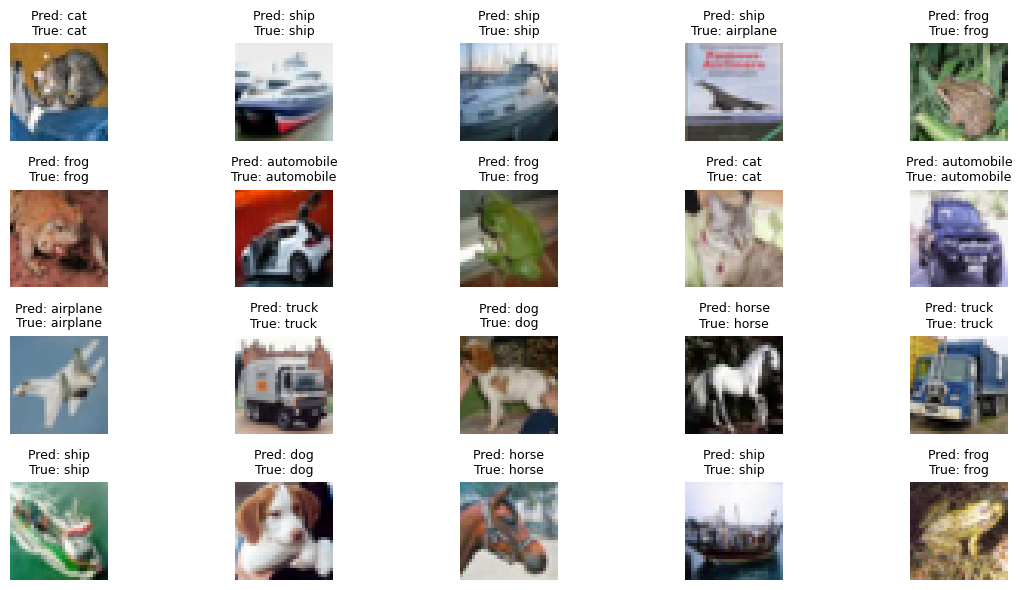

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# CIFAR-10 class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

model.eval()
images, labels = next(iter(val_data))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Define inverse normalization for CIFAR-10
inv_normalize = transforms.Normalize(
    mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
    std=[1/0.2470, 1/0.2435, 1/0.2616]
)

# Plot test images with predicted and true class names
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.subplot(4, 5, i+1)
    img_to_plot = inv_normalize(images[i].cpu()).clip(0, 1)
    plt.imshow(img_to_plot.permute(1, 2, 0))

    pred_name = classes[preds[i].item()]
    true_name = classes[labels[i].item()]

    plt.title(f"Pred: {pred_name}\nTrue: {true_name}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()

